In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('default')

from tqdm import tqdm

import tensorflow.keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Convolution2D, MaxPooling2D, Flatten , Activation, Input, BatchNormalization, Dropout, concatenate
from tensorflow.keras.utils import to_categorical

In [3]:
train_df = pd.read_csv('train_full.csv.gz')
test_df = pd.read_csv('test_full.csv.gz')
print(train_df.shape)
train_df.head()

(1320000, 25)


,_decision,_identifier,date_key,depth,epoch,longitude,latitude,home_region,elevation,seak,...,sunrise,sunset,hour,daytime,month,hours_to_transition,interval,period_progress,depth_class,_selected
0,0,tk129843,1388016000,75.3,1388018700,-166.720614,54.391059,UNKNOWN,-790.973118,0.0,...,19,2,0,1.0,12,2.0,7.0,0.714286,25,False
1,0,tk129843,1388016000,75.3,1388018700,-166.720614,54.391059,UNKNOWN,-790.973118,0.0,...,19,2,0,1.0,12,2.0,7.0,0.714286,50,False
2,0,tk129843,1388016000,75.3,1388018700,-166.720614,54.391059,UNKNOWN,-790.973118,0.0,...,19,2,0,1.0,12,2.0,7.0,0.714286,75,True
3,0,tk129843,1388016000,75.3,1388018700,-166.720614,54.391059,UNKNOWN,-790.973118,0.0,...,19,2,0,1.0,12,2.0,7.0,0.714286,100,False
4,0,tk129843,1388016000,75.3,1388018700,-166.720614,54.391059,UNKNOWN,-790.973118,0.0,...,19,2,0,1.0,12,2.0,7.0,0.714286,150,False


In [4]:
train_df.columns

Index(['_decision', '_identifier', 'date_key', 'depth', 'epoch', 'longitude',
       'latitude', 'home_region', 'elevation', 'seak', 'unknown', 'wa/or',
       'bc', 'datetime', 'date', 'sunrise', 'sunset', 'hour', 'daytime',
       'month', 'hours_to_transition', 'interval', 'period_progress',
       'depth_class', '_selected'],
      dtype='object')

In [5]:
def break_decisions(max_choices, dataframe):
    dataframes = [[] for _ in range(max_choices)]
    outcomes = []
    for _decision in tqdm(dataframe['_decision'].unique()):
        decision_df = dataframe[dataframe['_decision'] == _decision]
        for i, (_, row) in enumerate(decision_df.iterrows()):
            dataframes[i].append(row)
            if row['_selected']:
                outcomes.append(i)
        assert i == max_choices - 1
    return [pd.DataFrame(df) for df in dataframes], outcomes

X_trains_base, y_trains_base = break_decisions(10, train_df)
X_tests_base, y_tests_base = break_decisions(10, test_df)

100%|██████████| 90000/90000 [03:00<00:00, 497.77it/s]


We're going to start with a more standard classification problem. That means we're going to need to create single features per decision.

In [6]:
features = ['depth_class', 'month', 'daytime', 'period_progress', 'elevation']

X_trains = [np.array(X_train[features]) for X_train in X_trains_base]
X_tests = [np.array(X_test[features]) for X_test in X_tests_base]

full = np.array(pd.concat(X_trains_base)[features])
means = full.mean(axis=0)
stds = full.std(axis=0)

X_trains = [(X_train - means) / stds for X_train in X_trains]
X_tests = [(X_test - means) / stds for X_test in X_tests]

y_train = to_categorical(np.array(y_trains_base), num_classes=len(X_trains))
y_test = to_categorical(np.array(y_tests_base), num_classes=len(X_tests))

print(X_trains[0].shape)
X_trains[0]

(132000, 5)


array([[-1.20402011,  1.50599803,  0.97404874,  0.8919081 , -0.13464673],
       [-1.20402011, -1.55113709, -1.02664267,  1.63432457, -3.92282109],
       [-1.20402011, -1.55113709, -1.02664267,  1.38685241, -3.9616612 ],
       ...,
       [-1.20402011, -0.93971007,  0.97404874,  1.34877977,  0.45778905],
       [-1.20402011, -0.93971007,  0.97404874,  1.34877977,  0.51956365],
       [-1.20402011, -1.24542358, -1.02664267, -0.00799067,  0.51364886]])

In [7]:
def build_model(max_choices, features, layers, activation='linear'):
    layers.append(Dense(1, activation=activation))
    inputs = [Input(shape=(len(features),)) for _ in range(max_choices)]
    outcomes = []
    for input in inputs:
        last_layer = input
        for layer in layers:
            last_layer = layer(last_layer)
        outcomes.append(last_layer)

    outcomes = concatenate(outcomes)

    output_layer = Dense(max_choices, activation='softmax')
    output = output_layer(outcomes)
    output_layer.set_weights([np.eye(max_choices), np.zeros(max_choices)])
    output_layer.trainable = False

    model = Model(inputs=inputs, outputs=output)
    model.compile(optimizer='adam', loss='categorical_crossentropy')

    return model, layers

layers = [
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(8, activation='relu')
]

model, layers = build_model(len(X_trains), features, layers)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 5)]                  0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 5)]                  0         []                            
                                                                                                  
 input_3 (InputLayer)        [(None, 5)]                  0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 5)]                  0         []                            
                                                                                              

In [8]:
history=model.fit(X_trains, y_train,
                  validation_data=(X_tests,y_test),
                  batch_size=int(X_trains[0].shape[0] / 100),
                  epochs=50,
                  verbose=0,
                  shuffle=True)

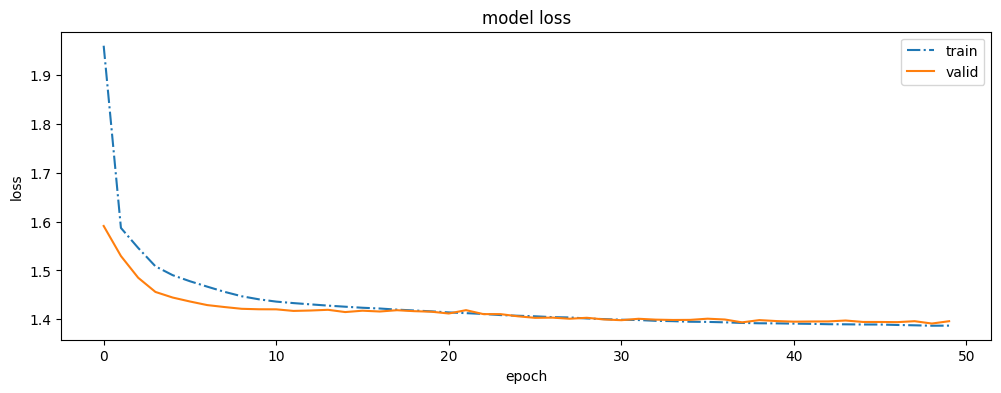

In [9]:
plt.figure(figsize=(12,4))
plt.plot(history.history['loss'],linestyle='-.')
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right');

In [10]:
print(min(history.history['loss']), min(history.history['val_loss']))
history.history['val_loss'][-1]

1.3868483304977417 1.3913140296936035


1.396102786064148

## Predict on a More Complete Set of Data

In [15]:
!pip install h3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 23.2 MB/s eta 0:00:00


In [31]:
import h3
from datetime import datetime, timedelta

# space
space_df = pd.concat([train_df[['latitude', 'longitude', 'elevation']], test_df[['latitude', 'longitude', 'elevation']]]).drop_duplicates()
space_df['h3_index'] = space_df.apply(lambda r: h3.geo_to_h3(r['latitude'], r['longitude'], 4), axis=1)
space_df = space_df.groupby('h3_index')[['elevation', 'latitude', 'longitude']].mean().reset_index()

# time
epochs = list(range(1704067200, 1704067200 + 59 * 24 * 3600 + 3600 * 3, 3600 * 3))
time_df = pd.DataFrame({"epoch": epochs})

df = time_df.merge(space_df, how='cross')
print(df.shape)
df.head()


(344344, 5)


,epoch,h3_index,elevation,latitude,longitude
0,1704067200,840c401ffffffff,-35.722226,60.112500,-146.900000
1,1704067200,840c403ffffffff,-116.401651,59.822727,-146.825000
2,1704067200,840c40bffffffff,-73.015721,60.062500,-146.075000
3,1704067200,840c411ffffffff,-434.044208,59.473864,-145.781818
4,1704067200,840c413ffffffff,-3048.331349,59.205357,-145.571429


In [25]:
!pip install suntimes

In [32]:
from suntimes import SunTimes


def get_sunrise(lat, lon, date):
    """
    Inputs:
    - lat: float, latitude
    - lon: float, longitude
    - date: str, date

    Outputs:
    - int, hour of sunrise
    """
    return SunTimes(longitude=lon, latitude=lat, altitude=0).risewhere(date, "UTC").hour


def get_sunset(lat, lon, date):
    """
    Inputs:
    - lat: float, latitude
    - lon: float, longitude
    - date: str, date

    Outputs:
    - int, hour of sunset
    """
    return SunTimes(longitude=lon, latitude=lat, altitude=0).setwhere(date, "UTC").hour

def add_time_features(data):
    data["datetime"] = pd.to_datetime(data["epoch"], utc=True, unit="s")
    data["date"] = data["datetime"].dt.date
    data = data[np.abs(data["longitude"]) <= 180]
    data["sunrise"] = data.apply(
        lambda r: get_sunrise(r["latitude"], r["longitude"], r["date"]), axis=1
    )
    data["sunset"] = data.apply(
        lambda r: get_sunset(r["latitude"], r["longitude"], r["date"]), axis=1
    )

    data["hour"] = data["datetime"].dt.hour

    data.loc[data["sunrise"] > data["sunset"], "daytime"] = (
        data["hour"] < data["sunset"]
    ) | (data["hour"] >= data["sunrise"])
    data.loc[data["sunrise"] < data["sunset"], "daytime"] = (
        data["hour"] >= data["sunrise"]
    ) & (data["hour"] < data["sunset"])

    data["month"] = data["datetime"].dt.month
    data["daytime"] = data["daytime"].astype(float)

    data["hours_to_transition"] = (
        (
            (data["hour"] > data["sunrise"]) * (24 - data["hour"] + data["sunrise"])
            + (data["hour"] <= data["sunrise"]) * (data["sunrise"] - data["hour"])
        )
        * (1 - data["daytime"])
    ).astype(float) + (
        (
            (data["hour"] > data["sunset"]) * (24 - data["hour"] + data["sunset"])
            + (data["hour"] <= data["sunset"]) * (data["sunset"] - data["hour"])
        )
        * (data["daytime"])
    ).astype(
        float
    )

    data["interval"] = (1 - data["daytime"]) * (
        (data["sunrise"] >= data["sunset"]) * (data["sunrise"] - data["sunset"])
        + (data["sunrise"] < data["sunset"]) * (24 - data["sunset"] + data["sunrise"])
    ) + (data["daytime"]) * (
        (data["sunset"] >= data["sunrise"]) * (data["sunset"] - data["sunrise"])
        + (data["sunset"] < data["sunrise"]) * (24 - data["sunrise"] + data["sunset"])
    )

    data["period_progress"] = (
        1 - data["hours_to_transition"] / data["interval"]
    ).astype(float)

    return data

df = add_time_features(df)
print(df.shape)
df.head()

(344344, 15)


,epoch,h3_index,elevation,latitude,longitude,datetime,date,sunrise,sunset,hour,daytime,month,hours_to_transition,interval,period_progress
0,1704067200,840c401ffffffff,-35.722226,60.112500,-146.900000,2024-01-01 00:00:00+00:00,2024-01-01,18,0,0,0.0,1,18.0,18.0,0.0
1,1704067200,840c403ffffffff,-116.401651,59.822727,-146.825000,2024-01-01 00:00:00+00:00,2024-01-01,18,0,0,0.0,1,18.0,18.0,0.0
2,1704067200,840c40bffffffff,-73.015721,60.062500,-146.075000,2024-01-01 00:00:00+00:00,2024-01-01,18,0,0,0.0,1,18.0,18.0,0.0
3,1704067200,840c411ffffffff,-434.044208,59.473864,-145.781818,2024-01-01 00:00:00+00:00,2024-01-01,18,0,0,0.0,1,18.0,18.0,0.0
4,1704067200,840c413ffffffff,-3048.331349,59.205357,-145.571429,2024-01-01 00:00:00+00:00,2024-01-01,18,0,0,0.0,1,18.0,18.0,0.0


In [33]:
X_preds = []
for depth_class in tqdm(sorted(train_df['depth_class'].unique())):
  X_pred = df.copy()
  X_pred['depth_class'] = depth_class
  X_pred = np.array(X_pred[features])
  X_pred = (X_pred - means) / stds
  X_preds.append(X_pred)

100%|██████████| 10/10 [00:00<00:00, 21.14it/s]


In [35]:
y_preds = model.predict(X_preds)

10761/10761 [==============================] - 38s 4ms/step


In [41]:
results = []
for i, depth_class in enumerate(sorted(train_df['depth_class'].unique())):
  result = df.copy()
  result['depth_class'] = depth_class
  result['probability'] = y_preds[:,i]
  results.append(result)

In [44]:
from shapely.geometry import Polygon
import geopandas as gpd

def get_coords(h3_index):
    """
    Input:
    - h3_index (str): A hex string representing the h3 index

    Returns a tuple of (lon, lat) coordinates for the h3 cell
        geometry
    """
    coords = h3.h3_to_geo_boundary(h3_index, True)
    coords = tuple((lon, lat) for lon, lat in coords)
    lons = [lon for lon, _ in coords]
    if max(lons) - min(lons) > 180:
        coords = tuple(
            (lon if lon > 0 else 180 + (180 + lon), lat) for lon, lat in coords
        )
    return coords

geoms = gpd.GeoDataFrame(
    [
        {
            "h3_index": key,
            "geometry": Polygon(get_coords(key)),
        }
        for key in df['h3_index'].unique()
    ]
)
geoms.head()

,h3_index,geometry
0,840c401ffffffff,"POLYGON ((-147.09373 60.35930, -147.50599 60.2..."
1,840c403ffffffff,"POLYGON ((-146.79181 60.04112, -147.19971 59.9..."
2,840c40bffffffff,"POLYGON ((-146.32217 60.35176, -146.73586 60.2..."
3,840c411ffffffff,"POLYGON ((-145.74675 59.71463, -146.15159 59.6..."
4,840c413ffffffff,"POLYGON ((-145.46987 59.39823, -145.87038 59.3..."


In [45]:
to_save = geoms.merge(results[0], on='h3_index', how='inner')
print(to_save.shape)
to_save.head()

(344344, 18)


,h3_index,geometry,epoch,elevation,latitude,longitude,datetime,date,sunrise,sunset,hour,daytime,month,hours_to_transition,interval,period_progress,depth_class,probability
0,840c401ffffffff,"POLYGON ((-147.09373 60.35930, -147.50599 60.2...",1704067200,-35.722226,60.1125,-146.9,2024-01-01 00:00:00+00:00,2024-01-01,18,0,0,0.0,1,18.0,18.0,0.000000,25,0.456116
1,840c401ffffffff,"POLYGON ((-147.09373 60.35930, -147.50599 60.2...",1704078000,-35.722226,60.1125,-146.9,2024-01-01 03:00:00+00:00,2024-01-01,18,0,3,0.0,1,15.0,18.0,0.166667,25,0.517544
2,840c401ffffffff,"POLYGON ((-147.09373 60.35930, -147.50599 60.2...",1704088800,-35.722226,60.1125,-146.9,2024-01-01 06:00:00+00:00,2024-01-01,18,0,6,0.0,1,12.0,18.0,0.333333,25,0.629399
3,840c401ffffffff,"POLYGON ((-147.09373 60.35930, -147.50599 60.2...",1704099600,-35.722226,60.1125,-146.9,2024-01-01 09:00:00+00:00,2024-01-01,18,0,9,0.0,1,9.0,18.0,0.500000,25,0.710253
4,840c401ffffffff,"POLYGON ((-147.09373 60.35930, -147.50599 60.2...",1704110400,-35.722226,60.1125,-146.9,2024-01-01 12:00:00+00:00,2024-01-01,18,0,12,0.0,1,6.0,18.0,0.666667,25,0.696552


In [50]:
to_save.to_wkt().to_csv('depth_class_25.csv.gz', index=False)